## Export 10yr Treasury Note Yield

In [10]:
import pandas_datareader as pdr
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import yahoo_fin.stock_info as yf_info
import yfinance as yf
from tqdm import tqdm

In [11]:
dow_list = yf_info.tickers_dow()
nasdaq_list = yf_info.tickers_nasdaq()
sp500_list = yf_info.tickers_sp500()

In [12]:
tickers = dow_list

In [13]:
Treasury_Note_10y = pdr.DataReader('DGS10', 'fred', start = '1960-01-01')
Treasury_Note_10y.index

DatetimeIndex(['1962-01-02', '1962-01-03', '1962-01-04', '1962-01-05',
               '1962-01-08', '1962-01-09', '1962-01-10', '1962-01-11',
               '1962-01-12', '1962-01-15',
               ...
               '2021-09-30', '2021-10-01', '2021-10-04', '2021-10-05',
               '2021-10-06', '2021-10-07', '2021-10-08', '2021-10-11',
               '2021-10-12', '2021-10-13'],
              dtype='datetime64[ns]', name='DATE', length=15597, freq=None)

## Export EPS and P/E history

In [14]:
print(tickers)

['AAPL', 'AMGN', 'AXP', 'BA', 'CAT', 'CRM', 'CSCO', 'CVX', 'DIS', 'DOW', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'JPM', 'KO', 'MCD', 'MMM', 'MRK', 'MSFT', 'NKE', 'PG', 'TRV', 'UNH', 'V', 'VZ', 'WBA', 'WMT']


In [15]:
Company_history_eps_info = {}
for ticker in tqdm(tickers):
    Company_history_eps_info[ticker] = pd.DataFrame(yf_info.get_earnings_history(ticker))

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [01:00<00:00,  2.00s/it]


In [16]:
Company_history_eps = {}
for ticker in tickers:
    Company_history_eps_info[ticker]['startdatetime'] = pd.to_datetime(pd.to_datetime(Company_history_eps_info[ticker]['startdatetime']).dt.strftime('%Y-%m-%d'))
    Company_history_eps[ticker] = Company_history_eps_info[ticker].set_index('startdatetime')[['epsestimate', 'epsactual']].dropna().sort_index()

In [17]:
Company_history_eps

{'AAPL':                epsestimate  epsactual
 startdatetime                        
 1996-04-17           -0.05      -0.07
 1996-07-17           -0.04      -0.02
 1996-10-16           -0.01       0.00
 1997-01-15           -0.02      -0.03
 1997-04-16           -0.04      -0.05
 ...                    ...        ...
 2020-07-30            0.51       0.65
 2020-10-29            0.70       0.73
 2021-01-27            1.41       1.68
 2021-04-28            0.99       1.40
 2021-07-27            1.01       1.30
 
 [96 rows x 2 columns],
 'AMGN':                epsestimate  epsactual
 startdatetime                        
 1997-10-22            0.17       0.17
 1998-01-22            0.17       0.17
 1998-04-22            0.17       0.18
 1998-07-22            0.18       0.21
 1998-10-27            0.20       0.21
 ...                    ...        ...
 2020-07-28            3.83       4.25
 2020-10-28            3.81       4.37
 2021-02-02            3.39       3.81
 2021-04-27           

In [18]:
Company_history_PE = {}
for ticker in tqdm(tickers):
    Company_history_PE[ticker] = pd.concat([yf.Ticker(ticker).history(period = 'max')['Close'], Company_history_eps[ticker]], axis = 1).dropna()

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:53<00:00,  1.77s/it]


In [19]:
Company_history_PE_YieldGap = {}
for ticker in tickers:
    Company_history_PE[ticker]['forwardPE'] = Company_history_PE[ticker]['Close']/(Company_history_PE[ticker]['epsestimate'].rolling(window = 4).sum())
    Company_history_PE[ticker]['tailingPE'] = Company_history_PE[ticker]['Close']/(Company_history_PE[ticker]['epsactual'].rolling(window = 4).sum())
    Company_history_PE[ticker]['forwardReturn'] = (Company_history_PE[ticker]['epsestimate'].rolling(window = 4).sum()) * 100 / Company_history_PE[ticker]['Close']
    Company_history_PE[ticker]['tailingReturn'] = (Company_history_PE[ticker]['epsactual'].rolling(window = 4).sum()) * 100 / Company_history_PE[ticker]['Close']
    Company_history_PE_YieldGap[ticker] = pd.concat([Company_history_PE[ticker], Treasury_Note_10y], axis = 1).dropna()
Company_history_PE_YieldGap['AAPL']

,Close,epsestimate,epsactual,forwardPE,tailingPE,forwardReturn,tailingReturn,DGS10
1997-01-15,0.132242,-0.02,-0.03,-1.102020,-1.102020,-90.742437,-90.742437,6.53
1997-04-16,0.142305,-0.04,-0.05,-1.293677,-1.423045,-77.299018,-70.271834,6.90
1997-07-16,0.126013,-0.02,-0.02,-1.400146,-1.260131,-71.421129,-79.356810,6.20
1998-01-14,0.151408,0.01,0.01,-2.162965,-1.682306,-46.232827,-59.442206,5.45
1998-04-15,0.210342,0.01,0.01,-5.258553,-4.206842,-19.016639,-23.770799,5.60
...,...,...,...,...,...,...,...,...
2020-07-30,95.403259,0.51,0.65,32.672349,28.910079,3.060692,3.459001,0.55
2020-10-29,114.583015,0.70,0.73,39.375607,35.040678,2.539643,2.853826,0.85
2021-01-27,141.395660,1.41,1.68,44.464044,38.215043,2.249008,2.616771,1.04
2021-04-28,133.153992,0.99,1.40,36.884762,29.855155,2.711147,3.349505,1.63


In [20]:
for ticker in tickers:
    Company_history_PE_YieldGap[ticker]['forward_YieldGap'] = Company_history_PE_YieldGap[ticker]['forwardReturn'] - Company_history_PE_YieldGap[ticker]['DGS10']
    Company_history_PE_YieldGap[ticker]['tailing_YieldGap'] = Company_history_PE_YieldGap[ticker]['tailingReturn'] - Company_history_PE_YieldGap[ticker]['DGS10']
Company_history_PE_YieldGap['AAPL']

,Close,epsestimate,epsactual,forwardPE,tailingPE,forwardReturn,tailingReturn,DGS10,forward_YieldGap,tailing_YieldGap
1997-01-15,0.132242,-0.02,-0.03,-1.102020,-1.102020,-90.742437,-90.742437,6.53,-97.272437,-97.272437
1997-04-16,0.142305,-0.04,-0.05,-1.293677,-1.423045,-77.299018,-70.271834,6.90,-84.199018,-77.171834
1997-07-16,0.126013,-0.02,-0.02,-1.400146,-1.260131,-71.421129,-79.356810,6.20,-77.621129,-85.556810
1998-01-14,0.151408,0.01,0.01,-2.162965,-1.682306,-46.232827,-59.442206,5.45,-51.682827,-64.892206
1998-04-15,0.210342,0.01,0.01,-5.258553,-4.206842,-19.016639,-23.770799,5.60,-24.616639,-29.370799
...,...,...,...,...,...,...,...,...,...,...
2020-07-30,95.403259,0.51,0.65,32.672349,28.910079,3.060692,3.459001,0.55,2.510692,2.909001
2020-10-29,114.583015,0.70,0.73,39.375607,35.040678,2.539643,2.853826,0.85,1.689643,2.003826
2021-01-27,141.395660,1.41,1.68,44.464044,38.215043,2.249008,2.616771,1.04,1.209008,1.576771
2021-04-28,133.153992,0.99,1.40,36.884762,29.855155,2.711147,3.349505,1.63,1.081147,1.719505


In [21]:
print(tickers)

['AAPL', 'AMGN', 'AXP', 'BA', 'CAT', 'CRM', 'CSCO', 'CVX', 'DIS', 'DOW', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'JPM', 'KO', 'MCD', 'MMM', 'MRK', 'MSFT', 'NKE', 'PG', 'TRV', 'UNH', 'V', 'VZ', 'WBA', 'WMT']


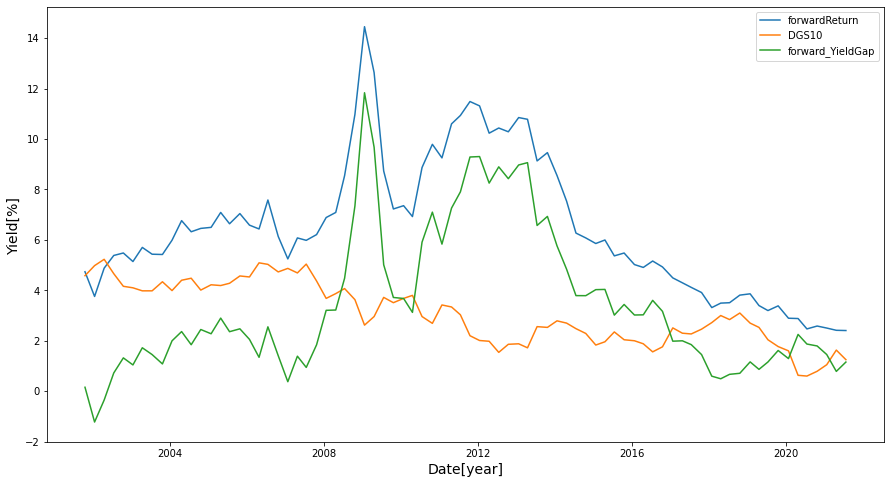

In [27]:
Company = 'MSFT'
plot_data = Company_history_PE_YieldGap[Company].tail(80)
plt.figure(figsize = (15,8))
plt.xlabel('Date[year]', fontsize = 14)
plt.ylabel('Yield[%]', fontsize = 14)
ax = sns.lineplot(data = plot_data,x=plot_data.index ,y=plot_data['forwardReturn'])
ax = sns.lineplot(data = plot_data,x=plot_data.index ,y=plot_data['DGS10'])
ax = sns.lineplot(data = plot_data,x=plot_data.index ,y=plot_data['forward_YieldGap'])
plt.legend(labels = ['forwardReturn','DGS10','forward_YieldGap'],loc = 'upper right')